In [238]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [239]:
exemplo = cv2.imread("imagem.jpg", 3)
exemplo = cv2.cvtColor(exemplo, cv2.COLOR_BGR2RGB)

## Introdução
A Protanopia e a Deoutoranopia são tipos específicos de daltonismo. O indivíduo com protanopia tem dificuldades de percepção de tons de cores vermelhos; e o indivíduo com deutoranopia tem dificuldades de percepção de tons de cores verdes. Tal dificuldade é causada por um mal funcionamento das células com a capacidade de reconhecimento de cores, chamadas cones.

No caso da protanopia, os cones L, responsáveis pela percepção de ondas de comprimento longos, associados à cor vermelha, não geram estímulos suficientes para intepretar a onda recebida; de mesmo modo, no caso da deutoranopia, os cones M, responsáveis pela percepção de ondas de comprimento médios, associados à cor verde.

Abaixo temos um gráfico com o espectro de cores visiveis em diferentes deficiências daltônicas:

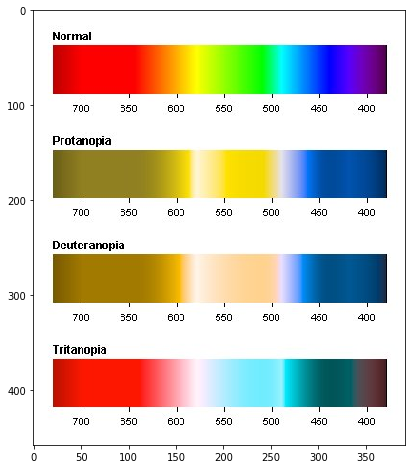

In [240]:
plt.figure(figsize=(8,8))
plt.imshow(exemplo)

## Objetivo
O objetivo deste projeto é simular a protanopia e deuteranopia. A partir do artigo "Digital Video Colourmaps for Checking the Legibility of Displays by Dichromats", de Françoise Viénot, Hans Brettel e John D. Mollon, publicado em Janeiro de 1999, os autores discutem a relação entre o modelo de cor RGB, comumente associado à imagens reproduzidas em dispositivos eletrônicos, e o modelo LMS, baseado nos 3 comprimentos de onda que o olho humano é capaz de interpretar como cores, graças às células cones. Com a relação entre os dois modelos fundamentada, os autores associam a questão da protanopia e da deuteranopia com a relação entre o modelo LMS e RGB, assim obtendo um caminho para a simulação desejada neste projeto.

## Metodologia Vienot-Brettel-Mollon
O trabalho se baseará na transformação da imagem abaixo, uma vez para simulação de protanopia e outra para deuteranopia

Os passos para a transformação de imagens para protanopia e deuteranopia de acordo com o artigo são:

**1** - Converter os valores de 8 bits do conversor digital-analógico (DAC) para valores RGB, invertendo os valores gamma do monitor (gamut compression);

\begin{align}
R & = (I/255)^{2.2} \\
G & = (J/255)^{2.2} \\
B & = (K/255)^{2.2}
\end{align}


**2** - Redução do domínio das cores para a compatibilidade do monitor para correção da colorimetria do monitor.

Para protanopia:
\begin{align}
R_2 & = 0.992052 \cdot R + 0.003974  \\
G_2 & = 0.992052 \cdot G + 0.003974  \\
B_2 & = 0.992052 \cdot B + 0.003974
\end{align}

Para deuteranopia:
\begin{align}
R_2 & = 0.957237 \cdot R + 0.0213814  \\
G_2 & = 0.957237 \cdot G + 0.0213814  \\
B_2 & = 0.957237 \cdot B + 0.0213814
\end{align}

**3** - Baseado na recomendação ITU-R BT709 e nas transformações colorimétricas de Judd-Vos, e Smith e Pokorny, fazer a transformação do dominio RGB obtidos no passo 2 para o dominio LMS

\begin{align}
\begin{bmatrix}
L \\ M \\ S
\end{bmatrix} =
\begin{bmatrix}
17.8824 & 43.5161 & 4.11935 \\ 3.45565 & 27.1554 & 3.86714 \\ 0.0299566 & 0.184309 & 1.46709
\end{bmatrix}
\times 
\begin{bmatrix}
R_2 \\ G_2 \\ B_2
\end{bmatrix}
\end{align}

**4** - Redução do dominio LMS para o dominio das cores LMS com protanopia e deuteranopia

Para protanopia:
\begin{align}
\begin{bmatrix}
L_p \\ M_p \\ S_p
\end{bmatrix} =
\begin{bmatrix}
0 & 2.02344 & -2.52581 \\ 0 & 1 & 0 \\ 0 & 0 & 1
\end{bmatrix}
\times 
\begin{bmatrix}
L \\ M \\ S
\end{bmatrix}
\end{align}

Para deuteranopia:
\begin{align}
\begin{bmatrix}
L_d \\ M_d \\ S_d
\end{bmatrix} =
\begin{bmatrix}
1 & 0 & 0 \\ 0.494207 & 0 & 1.24827 \\ 0 & 0 & 1
\end{bmatrix}
\times 
\begin{bmatrix}
L \\ M \\ S
\end{bmatrix}
\end{align}

**5** - Com os valores do domínio LMS alteradas para simular a protanopia e deuteranopia, reverter para o domínio RGB

\begin{align}
\begin{bmatrix}
R_{mod} \\ G_{mod} \\ B_{mod}
\end{bmatrix} = \begin{bmatrix}
0.080944 &  -0.130504 & 0.116721 \\ - 0.0102485 & 0.0540194 & -0.113615 \\ -0.000365294 & -0.00412163 & 0.693513
\end{bmatrix}
\times 
\begin{bmatrix}
L_{mod} \\ M_{mod} \\ S_{mod}
\end{bmatrix}
\end{align}

In [241]:
def transforma_vbm(img, tipo):
    rgb = deepcopy(img)
    
    # 1 - Quantidades fotométricas relativas de R,G,B
    
    rgb = (rgb/255)**2.2
    #rgb = rgb*1.0
    
    
    # 2 - Redução do dom;inio das cores
    
    if tipo == "protanopia":
        rgb[:,:,:] *= 0.992052
        rgb[:,:,:] += 0.003974
    elif tipo == "deuteranopia":
        rgb[:,:,:] *=  0.957237
        rgb[:,:,:] += 0.0213814
    
    else: return 1
    
    # 3
    
    lms = np.zeros(img.shape)
    lms[:,:,0] = rgb[:,:,0]*17.8824 + rgb[:,:,1]*43.5161 + rgb[:,:,2]*4.11935
    lms[:,:,1] = rgb[:,:,0]*3.45565 + rgb[:,:,1]*27.1554 + rgb[:,:,2]*3.86714
    lms[:,:,2] = rgb[:,:,0]*0.0299566 + rgb[:,:,1]*0.184309 + rgb[:,:,2]*1.46709
    
    lms_mod = np.zeros(img.shape)
    if tipo == "protanopia":
        lms_mod[:,:,0] = lms[:,:,0]*0 + lms[:,:,1]*2.02344 + lms[:,:,2]*(-2.52581)
        lms_mod[:,:,1] = lms[:,:,0]*0 + lms[:,:,1]*1 + lms[:,:,2]*0
        lms_mod[:,:,2] = lms[:,:,0]*0 + lms[:,:,1]*0 + lms[:,:,2]*1 
    elif tipo == "deuteranopia":
        lms_mod[:,:,0] = lms[:,:,0]*1 + lms[:,:,1]*0 + lms[:,:,2]*0
        lms_mod[:,:,1] = lms[:,:,0]*0.494207 + lms[:,:,1]*0 + lms[:,:,2]*1.24827
        lms_mod[:,:,2] = lms[:,:,0]*0 + lms[:,:,1]*0 + lms[:,:,2]*1
        
    rgb_mod = deepcopy(lms_mod)
    rgb_mod[:,:,0] = lms_mod[:,:,0]*0.080944 + lms_mod[:,:,1]*(-0.130504) + lms_mod[:,:,2]*0.116721
    rgb_mod[:,:,1] = lms_mod[:,:,0]*(-0.0102485) + lms_mod[:,:,1]*0.0540194 + lms_mod[:,:,2]*(-0.113615)
    rgb_mod[:,:,2] = lms_mod[:,:,0]*(-0.000365294) + lms_mod[:,:,1]*(-0.00412163) + lms_mod[:,:,2]*0.693513
    
    return (255*(rgb_mod**(1/2.2))).astype(int)
    #return rgb_mod.astype(int)

## Resultados

Comparação com as imagens do artigo. No artigo utilizando esse método, foram produzidas uma imagem de protanopia e deuteranopia das linhas de metro de Paris. Pode-se observar os testes de Protanopia Controle e Deuteranopia Controle, que foram diretamente retiradas do artigo, em comparação com as imagens geradas pelo grupo.

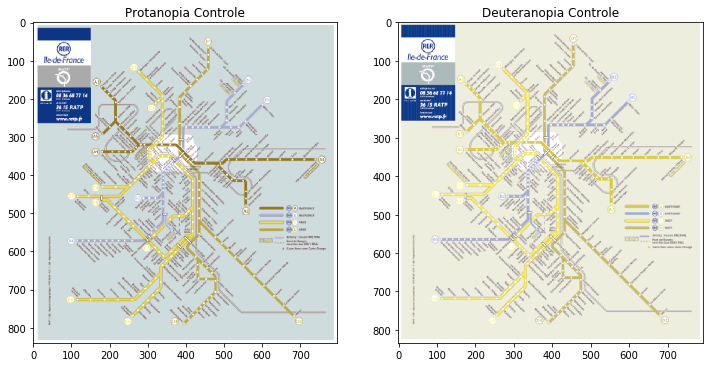

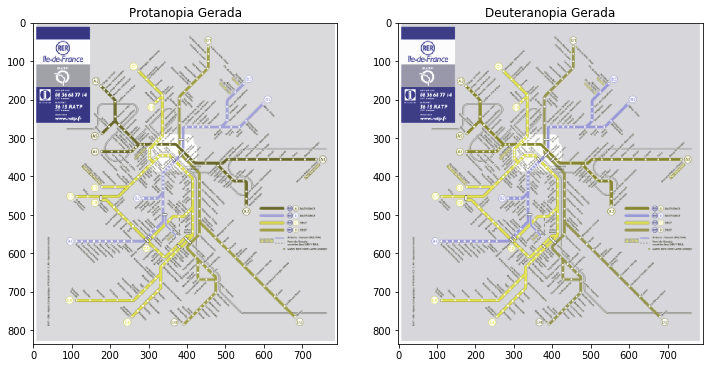

In [242]:
normal = cv2.cvtColor(cv2.imread("normal.png", 3), cv2.COLOR_BGR2RGB)
protan_control = cv2.cvtColor(cv2.imread("protan.png", 3), cv2.COLOR_BGR2RGB)
deutan_control = cv2.cvtColor(cv2.imread("deutan.png", 3), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.title("Protanopia Controle")
plt.imshow(protan_control)
plt.subplot(122)
plt.title("Deuteranopia Controle")
plt.imshow(deutan_control)

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.title("Protanopia Gerada")
plt.imshow(transforma_vbm(deepcopy(normal), "protanopia"))
plt.subplot(122)
plt.title("Deuteranopia Gerada")
plt.imshow(transforma_vbm(deepcopy(normal), "deuteranopia"))


Comparação de imagens geradas com os espectros de daltonismo. Para checar o quão precisas essas imagens ficaram, deve se comparar o Normal Visto com Protanopia e o Normal Visto com Deuteranopia com os espectros de Protanopia e Deuteranopia do Controle

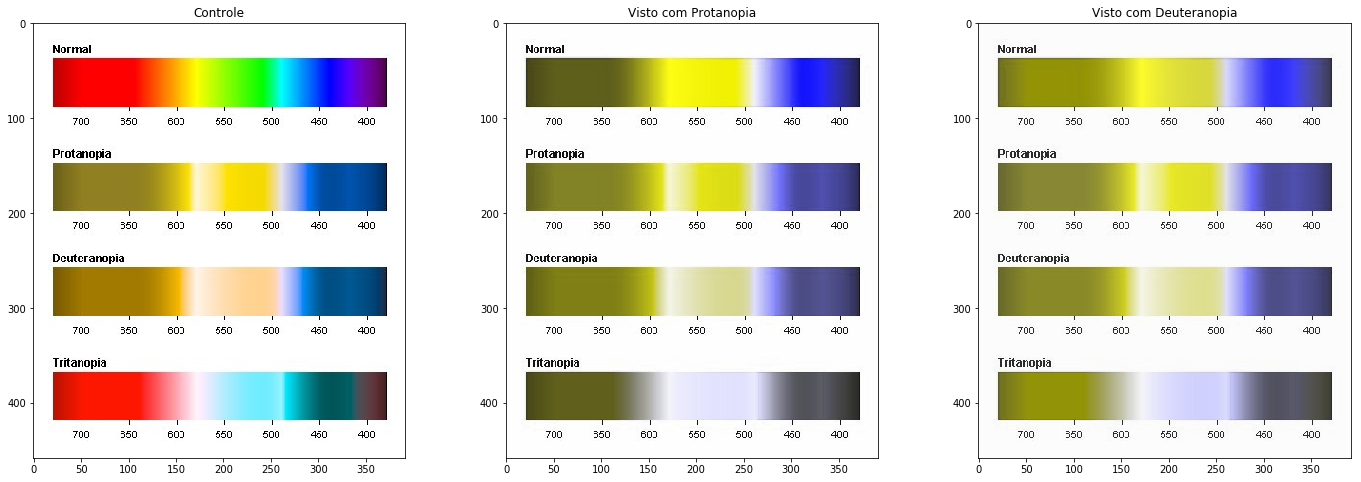

In [243]:
plt.figure(figsize=(24,8))
plt.subplot(131)
plt.title("Controle")
plt.imshow(exemplo)
plt.subplot(132)
plt.title("Visto com Protanopia")
plt.imshow(transforma_vbm(deepcopy(exemplo), "protanopia"))
plt.subplot(133)
plt.title("Visto com Deuteranopia")
plt.imshow(transforma_vbm(deepcopy(exemplo), "deuteranopia"))

Por conta do resultado mediamente insatisfatório, o grupo decidiu testar implementações alternativas, uma vez que os efeitos do método de Vienot-Brettel-Mollon. Esse resultado pode ter sido dado por algumas razões:

* Imprecisões da imagem. Como não foi possível encontrar a fonte original da imagem, foi utilizada a imagem adquirida no PDF do artigo, que pode ter sofrido uma perda de qualidade nas cores. Por esse motivo o resultado pode ter ficado alterado.
* As propriedades do monitor utilizadas no artigo pode não estar de acordo com as propriedades utilizadas na imagem, então em comparação com as imagem gerada no artigo e a gerada pelo grupo os resultados podem divergir.
* Erros de implementação do método.

## Metodologia Color Blindness SImulation

O método de Color Blindness Simulation é utilizado na biblioteca de processamento de imagem ColorBlindness por ixora.io. Ela é utilizada no Processing 3 de C.

Essa metodologia uma principios muito similares ao método Vienot-Brettel-Mollon, inclusive tendo esse artigo citado na pesquisa do ixora.io.

Consiste em transformar a imagem RGB para o plano LMS, realizar transformações nas cores presentes para descrescer uma quantidade certa de cada componente de cor e transformar novamente para o domínio RGB. Uma das vantagens dessa implementação é que ela tem suporte para tritanopia.

1. Correção de Gamma, usando uma troca de métrica
<img src="files/CBS1.png" width="300">
2. Transformação para LMS
<img src="files/CBS2.png" width="400">
3. Transformações de daltonismo
Para protanopia
<img src="files/SP.png" width="300">
Para deuteranopia
<img src="files/SD.png" width="300">
Para tritanopia
<img src="files/ST.png" width="300">
4. Conversão de volta para RGB
<img src="files/CBS3.png" width="300">
5. Recorreção de Gamma
<img src="files/CBS3.png" width="300">

Fonte: https://ixora.io/projects/colorblindness/color-blindness-simulation-research/



In [244]:
def gammaCorrect(int, Vcolor):
    
    if int > Vcolor:
        return (((int/255)+0.055)/1.055)**2.4
    else:
        return (int/255)/12.92
        

def gammaDecorrect(int, Vcolor):
    
    if int > Vcolor:
        return 255*(int*12.92)
    else:
        return 255*(((int**0.41666)*1.055)-0.055)
        

def transforma_cbs(img, tipo):
    rgb = deepcopy(img)
    
    # 1 - Correção de gamma
    
    Vcolor = 0.04045*255
    
    rgb_l = deepcopy(rgb)
    
    for linha in np.nditer(rgb_l):
        for ponto in np.nditer(linha):
            for cor in np.nditer(ponto):
                cor = gammaCorrect(cor,Vcolor)
    
    lms = np.zeros(img.shape) #deepcopy(lms_i)
    lms[:,:,0] = rgb_l[:,:,0]*0.31399022 + rgb_l[:,:,1]*0.63951294 + rgb_l[:,:,2]*0.04649755
    lms[:,:,1] = rgb_l[:,:,0]*0.15537241 + rgb_l[:,:,1]*0.75789446 + rgb_l[:,:,2]*0.08670142
    lms[:,:,2] = rgb_l[:,:,0]*0.01775239 + rgb_l[:,:,1]*0.10944209 + rgb_l[:,:,2]*0.87256922
    
    
    lms_mod = np.zeros(img.shape)#deepcopy(lms)
    if tipo == "protanopia":
        # SP
        lms_mod[:,:,0] = lms[:,:,0]*0 + lms[:,:,1]*1.05118294 + lms[:,:,2]*(-0.05116099)
        lms_mod[:,:,1] = lms[:,:,0]*0 + lms[:,:,1]*1 + lms[:,:,2]*0
        lms_mod[:,:,2] = lms[:,:,0]*0 + lms[:,:,1]*0 + lms[:,:,2]*1
    if tipo == "deuteranopia":
        lms_mod[:,:,0] = lms[:,:,0]*1 + lms[:,:,1]*0 + lms[:,:,2]*0
        lms_mod[:,:,1] = lms[:,:,0]*0.9513092 + lms[:,:,1]*0 + lms[:,:,2]*0.04866992
        lms_mod[:,:,2] = lms[:,:,0]*0 + lms[:,:,1]*0 + lms[:,:,2]*1
    if tipo == "tritanopia":
        lms_mod[:,:,0] = lms[:,:,0]*1 + lms[:,:,1]*0 + lms[:,:,2]*0
        lms_mod[:,:,1] = lms[:,:,0]*0 + lms[:,:,1]*1 + lms[:,:,2]*0
        lms_mod[:,:,2] = lms[:,:,0]*(-0.86744736) + lms[:,:,1]*1.86727089 + lms[:,:,2]*1
    
    # De volta para RGB
    
    rgb_mod = np.zeros(img.shape)#deepcopy(lms_mod)
    rgb_mod[:,:,0] = lms_mod[:,:,0]*5.47221206 + lms_mod[:,:,1]*(-4.6419601) + lms_mod[:,:,2]*0.16963708
    rgb_mod[:,:,1] = lms_mod[:,:,0]*(-1.1252419) + lms_mod[:,:,1]*2.29317094 + lms_mod[:,:,2]*(-0.1678952)
    rgb_mod[:,:,2] = lms_mod[:,:,0]*0.02980165 + lms_mod[:,:,1]*(-0.19318073) + lms_mod[:,:,2]*1.16364789
    
    
                
    for linha in np.nditer(rgb_mod):
        for ponto in np.nditer(linha):
            for cor in np.nditer(ponto):
                cor = gammaDecorrect(cor,0.0031308)
    
    
    

    return np.clip(rgb_mod.astype(int),0,255)
    #return rgb_mod.astype(int)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  


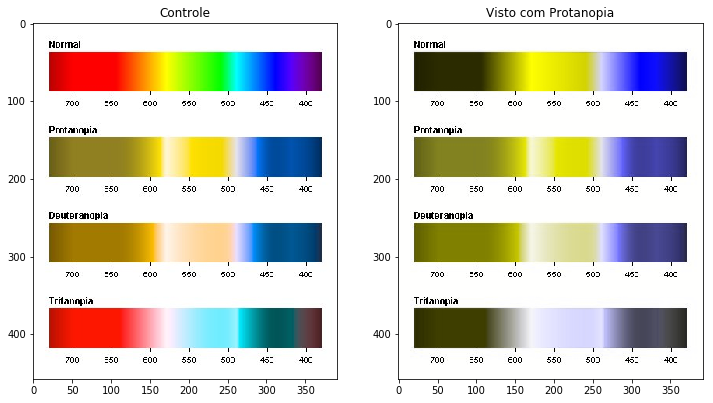

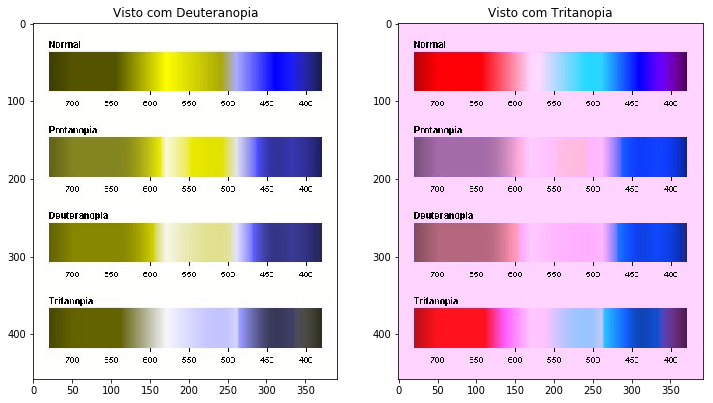

In [245]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.title("Controle")
plt.imshow(exemplo)
plt.subplot(122)
plt.title("Visto com Protanopia")
plt.imshow(transforma_cbs(deepcopy(exemplo), "protanopia"))
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.title("Visto com Deuteranopia")
plt.imshow(transforma_cbs(deepcopy(exemplo), "deuteranopia"))
plt.subplot(122)
plt.title("Visto com Tritanopia")
plt.imshow(transforma_cbs(deepcopy(exemplo), "tritanopia"))

Os resultados desse método não foram tão precisos em relação à deuteranopia e protanopia, porém os resultados da tritanopia foram muito conclusivos. Daltônicos com tritanopia não enchergam a cor branca corretamente, tendo essa cor de forma mais rosada, além disso o espectro ficou com uma aparência muito similar. 

### Resultados

Os resultados dados por ambos os métodos não coincidiu tanto com os espectros quanto o grupo gostaria, porém eles coincidiram bastante entre si. Essa coincidência entre métodos diferentes leva à uma validação do trabalho do grupo, uma vez que indica uma menor possibilidade na falha da aplicação em Python, e maior em relação à questões de teoria. Dessa forma, podemos comparar as imagens geradas por ambos os métodos e concluir uma possível representação da visão de daltonismos de tipo de protanopia e deuteranopia

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  


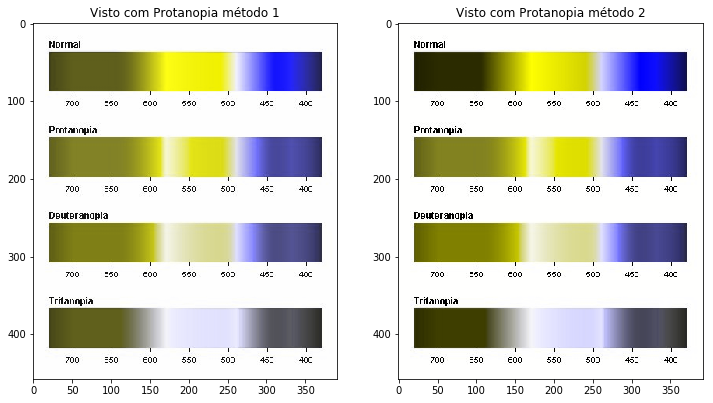

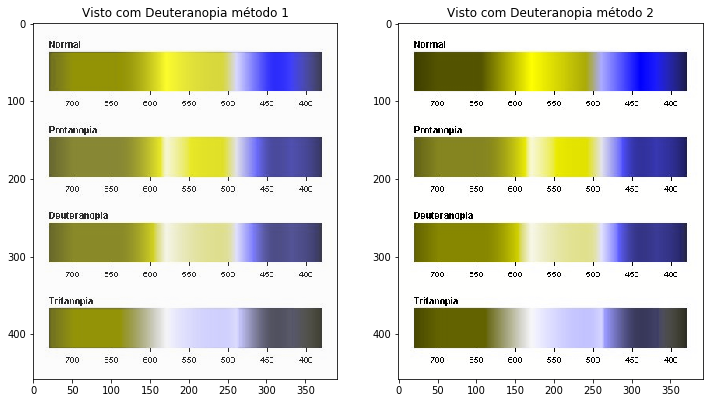

In [246]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.title("Visto com Protanopia método 1")
plt.imshow(transforma_vbm(deepcopy(exemplo), "protanopia"))
plt.subplot(122)
plt.title("Visto com Protanopia método 2")
plt.imshow(transforma_cbs(deepcopy(exemplo), "protanopia"))
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.title("Visto com Deuteranopia método 1")
plt.imshow(transforma_vbm(deepcopy(exemplo), "deuteranopia"))
plt.subplot(122)
plt.title("Visto com Deuteranopia método 2")
plt.imshow(transforma_cbs(deepcopy(exemplo), "deuteranopia"))

Uma das coisas mais interessantes foi o fato da tritanopia ter ficado muito precisa. Coincidindo com o espcetro precisamente.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  


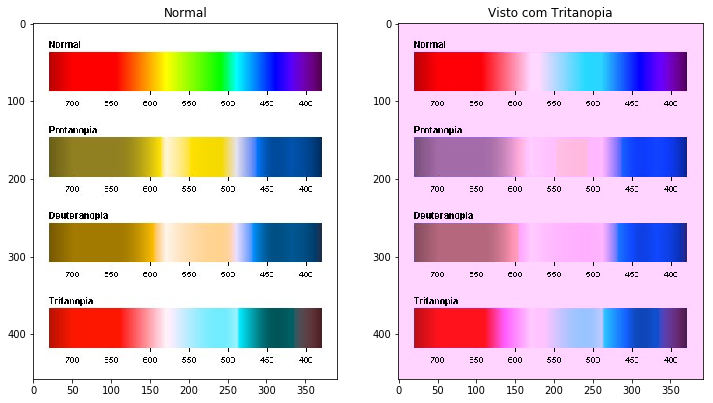

In [247]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.title("Normal")
plt.imshow(exemplo)
plt.subplot(122)
plt.title("Visto com Tritanopia")
plt.imshow(transforma_cbs(deepcopy(exemplo), "tritanopia"))